In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
import librosa

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2


In [2]:
# Establecemos semilla para garantizar reproducibilidad de resultados
np.random.seed(42)

#### El dataset se creó para identificar una voz como masculina o femenina, según las propiedades acústicas de la voz y el habla.El conjunto de datos consta de 3168 muestras de voz grabadas, recopiladas de hombres y mujeres. Las muestras de voz son preprocesadas mediante análisis acústico en R utilizando los paquetes seewave y tuneR, con un rango de frecuencia analizado de 0hz-280hz (rango vocal humano).

In [4]:
# Cargar el conjunto de datos
df = pd.read_csv('voice.csv')
X = df.drop(columns=['label'])  # Excluir la columna 'label' como características
y = df['label']


Funcion para aplicar data augmentation aplicando las siguientes transformaciones : - Traslación
                                                                                   - Escalado
                                                                                   - Clipping
                                                                                   - Pitch Shifting
                                                                                   - Ruido Aleatorio
                                                      

In [3]:
# Función para aplicar aumentos de datos convencionales
def apply_data_augmentation(X, y, num_augmentations=15, translation_shift=10, scale_range=(0.8, 1.2), clipping=True, sample_rate=44100):
    augmented_data = []
    augmented_labels = []

    for i in range(X.shape[0]):
        for _ in range(num_augmentations):
            # Traslación
            X_translated = np.roll(X[i], shift=np.random.randint(-translation_shift, translation_shift))

            # Escalado
            scale_factor = np.random.uniform(scale_range[0], scale_range[1])
            X_scaled = X[i] * scale_factor
            
            # Aplicar clipping si es necesario
            if clipping:
                X_scaled = np.clip(X_scaled, a_min=0, a_max=1)

            augmented_data.extend([X_translated, X_scaled])
            augmented_labels.extend([y[i]] * 2)  # Replicar etiqueta para las instancias aumentadas

            # Cambio de tono (Pitch Shifting)
            semitone_shift_value = np.random.uniform(-2, 2)  # Ajusta según tus necesidades
            X_pitch_shifted = librosa.effects.pitch_shift(X[i], sr=sample_rate, n_steps=semitone_shift_value)
            augmented_data.append(X_pitch_shifted)
            augmented_labels.append(y[i])

            # Ruido Aleatorio
            noise_level = np.random.uniform(0, 0.01)  # Ajusta según tus necesidades
            X_noisy = X[i] + np.random.normal(0, noise_level, len(X[i]))
            augmented_data.append(X_noisy)
            augmented_labels.append(y[i])

    return np.array(augmented_data), np.array(augmented_labels)


In [5]:
# División del conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

#### Normalización de los datos de entrenamiento, validación y prueba

In [6]:
# Inicializar el objeto MinMaxScaler
scaler = MinMaxScaler()

# Ajustar el scaler en el conjunto de entrenamiento y transformar los conjuntos de entrenamiento, validación y prueba
X_train_normalized = scaler.fit_transform(X_train)
X_val_normalized = scaler.transform(X_val)
X_test_normalized = scaler.transform(X_test)

In [7]:
"""# Normaliza los datos (opcional pero a menudo beneficioso para las redes neuronales)
X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_val = (X_val - X_train.min()) / (X_train.max() - X_train.min())
X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())
"""

'# Normaliza los datos (opcional pero a menudo beneficioso para las redes neuronales)\nX_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())\nX_val = (X_val - X_train.min()) / (X_train.max() - X_train.min())\nX_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())\n'

In [8]:
# Convertir etiquetas(labels) a formato numérico
y_train = y_train.map({'male': 0, 'female': 1})
y_val = y_val.map({'male': 0, 'female': 1})
y_test = y_test.map({'male': 0, 'female': 1})

In [ ]:
# Aplicar aumentos a los datos de entrenamiento
X_train_augmented, y_train_augmented = apply_data_augmentation(X_train_normalized, y_train.values, num_augmentations=15)

In [10]:
# Asegurarse de que las dimensiones sean compatibles
X_train_augmented = X_train_augmented[:, :, np.newaxis]

In [11]:
# Antes de la aumentación
print(f"Número de muestras antes de la aumentación: {X_train_normalized.shape[0]}")
# Después de la aumentación
print(f"Número de muestras después de la aumentación: {X_train_augmented.shape[0]}")

Número de muestras antes de la aumentación: 2027
Número de muestras después de la aumentación: 121620


In [12]:
# Aplicar aumentos a los datos de validación
X_val_augmented, y_val_augmented = apply_data_augmentation(X_val_normalized, y_val.values, num_augmentations=15)

# Asegurarse de que las dimensiones sean compatibles
X_val_augmented = X_val_augmented[:, :, np.newaxis]

# Antes de la aumentación
print(f"Número de muestras en el conjunto de validación antes de la aumentación: {X_val_normalized.shape[0]}")

# Después de la aumentación
print(f"Número de muestras en el conjunto de validación después de la aumentación: {X_val_augmented.shape[0]}")

Número de muestras en el conjunto de validación antes de la aumentación: 507
Número de muestras en el conjunto de validación después de la aumentación: 30420


Model: LogisticRegression
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       337
           1       0.96      0.91      0.93       297

    accuracy                           0.94       634
   macro avg       0.94      0.94      0.94       634
weighted avg       0.94      0.94      0.94       634

[[326  11]
 [ 28 269]]


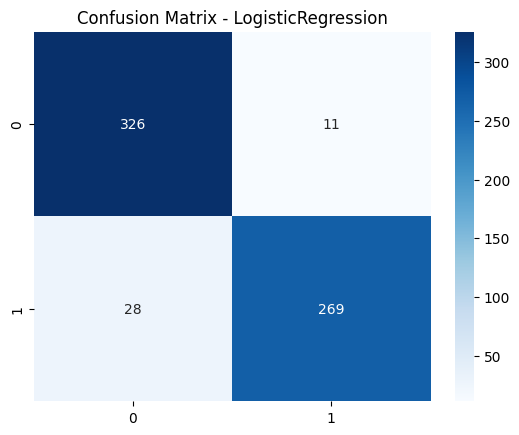

Model: RandomForestClassifier
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       337
           1       0.97      0.99      0.98       297

    accuracy                           0.98       634
   macro avg       0.98      0.98      0.98       634
weighted avg       0.98      0.98      0.98       634

[[329   8]
 [  4 293]]


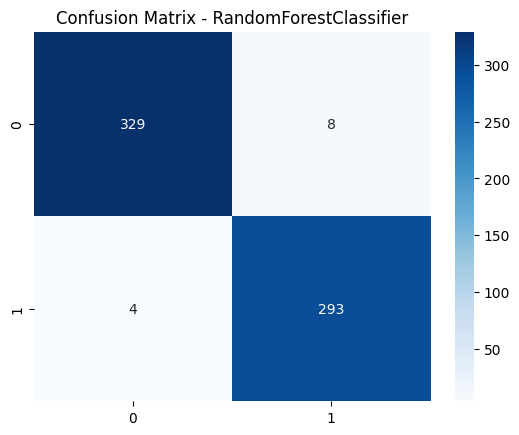

Model: SVC
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       337
           1       0.97      0.99      0.98       297

    accuracy                           0.98       634
   macro avg       0.98      0.98      0.98       634
weighted avg       0.98      0.98      0.98       634

[[329   8]
 [  4 293]]


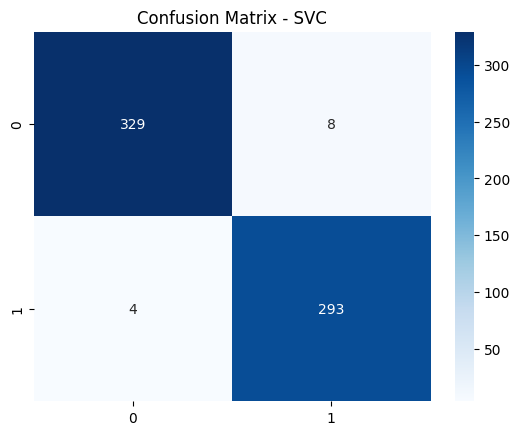

In [13]:
# Entrenamiento y evaluación de modelos
models = [
    LogisticRegression(),
    RandomForestClassifier(),
    SVC(), 
]

for model in models:
    model.fit(X_train_augmented.reshape((X_train_augmented.shape[0], -1)), y_train_augmented)
    y_pred = model.predict(X_test_normalized)

    # Evalúa el modelo
    print(f"Model: {model.__class__.__name__}")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

    # Gráficos y visualizaciones
    plt.figure()
    plt.title(f"Confusion Matrix - {model.__class__.__name__}")
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.show()

In [15]:
# Reformatear los datos para que sean compatibles con RNN
X_train_rnn = X_train_augmented.reshape((X_train_augmented.shape[0], X_train_augmented.shape[1], 1))
X_val_rnn = X_val_augmented.reshape((X_val_augmented.shape[0], X_val_augmented.shape[1], 1))
X_test_rnn = X_test_normalized.reshape((X_test_normalized.shape[0], X_test_normalized.shape[1], 1))

In [16]:
# Monitoreo en tiempo real con EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [ ]:
# Configurar validación cruzada
num_folds = 5  # Puedes ajustar este valor según tus necesidades
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Almacenar métricas de rendimiento para cada fold
acc_per_fold = []
loss_per_fold = []

# Definir el modelo
def create_model():
    model = Sequential([
        LSTM(64, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train_rnn.shape[1], 1), return_sequences=True),
        BatchNormalization(),
        Dropout(0.5),
        
        LSTM(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Entrenamiento con validación cruzada
fold_no = 1
for train, test in kfold.split(X_train_rnn, y_train_augmented):
    model = create_model()

    history = model.fit(X_train_rnn[train], y_train_augmented[train], epochs=100, batch_size=4096, validation_data=(X_val_rnn, y_val_augmented),callbacks=[early_stopping])

    # Evaluar el modelo en el conjunto de prueba del fold actual
    scores = model.evaluate(X_train_rnn[test], y_train_augmented[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no += 1

# Mostrar el rendimiento promedio en todos los folds
print(f'Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'Loss: {np.mean(loss_per_fold)} (+- {np.std(loss_per_fold)})')

In [19]:
# Obtener las probabilidades y predicciones en el conjunto de validación
y_val_prob_rnn = model.predict(X_val_rnn)
y_val_pred_rnn = (y_val_prob_rnn > 0.5).astype("int32")

# Evaluar el modelo en el conjunto de validación
print("RNN Model en conjunto de validación:")
print(classification_report(y_val_augmented, y_val_pred_rnn))
print("Confusion Matrix:")
print(confusion_matrix(y_val_augmented, y_val_pred_rnn))

951/951 [==============================] - 12s 13ms/step
RNN Model en conjunto de validación:
              precision    recall  f1-score   support

           0       0.97      0.90      0.93     15780
           1       0.90      0.97      0.93     14640

    accuracy                           0.93     30420
   macro avg       0.93      0.94      0.93     30420
weighted avg       0.94      0.93      0.93     30420

Confusion Matrix:
[[14246  1534]
 [  477 14163]]


In [20]:
# Evaluar el modelo en el conjunto de prueba
y_prob_rnn = model.predict(X_test_rnn)
y_pred_rnn = (y_prob_rnn > 0.5).astype("int32")

20/20 [==============================] - 0s 13ms/step


In [23]:
# Mostrar resultados
print("RNN Model:")
print(classification_report(y_test, y_pred_rnn))
print(confusion_matrix(y_test, y_pred_rnn))

RNN Model:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       337
           1       0.95      0.99      0.97       297

    accuracy                           0.97       634
   macro avg       0.97      0.97      0.97       634
weighted avg       0.97      0.97      0.97       634

[[320  17]
 [  4 293]]


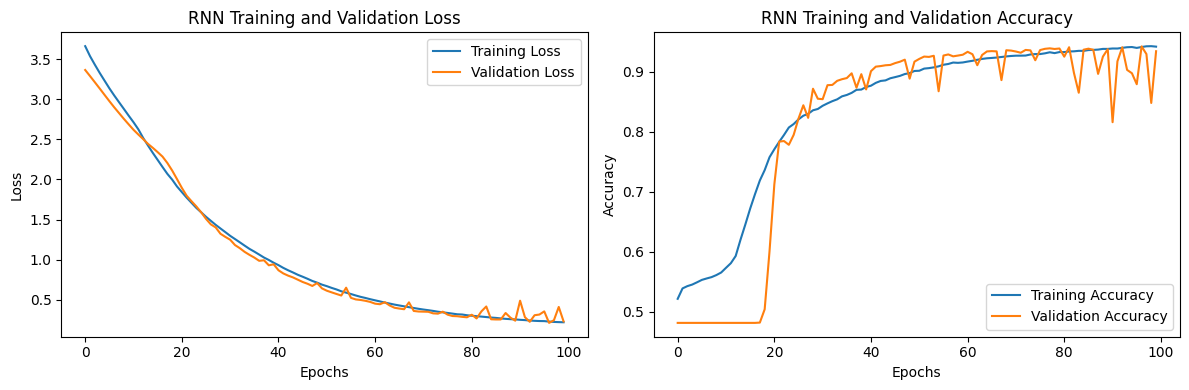

In [25]:
# Visualización de la curva de aprendizaje
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('RNN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('RNN Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

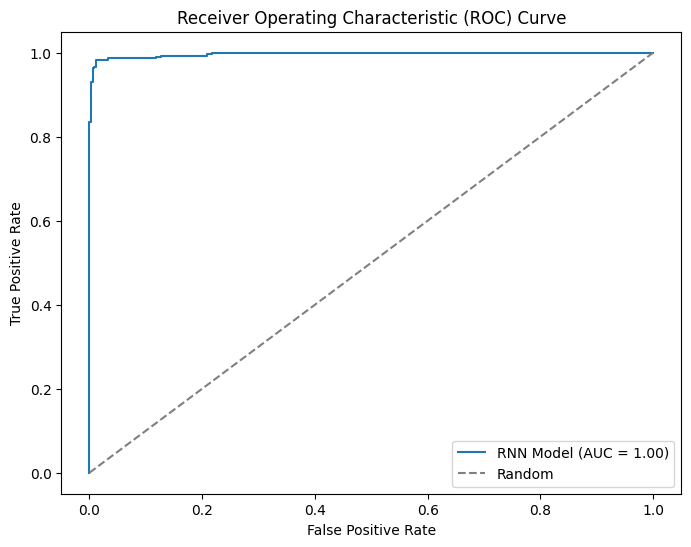

In [26]:
# Agregar la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_prob_rnn)
roc_auc = roc_auc_score(y_test, y_prob_rnn)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'RNN Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Random')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [25]:
# Guardar el modelo en formato h5
model_rnn.save('voice_Recognition.h5')